In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/Dataset/All_oranges_Drive_Augmented"
test_dir = "/content/drive/MyDrive/Dataset/Test_Data"
batch_size = 32
target_size = (224, 224)
epochs = 50

# **Datset**

In [4]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in or out on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)


print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 5961 images belonging to 2 classes.
Found 1490 images belonging to 2 classes.
Training samples: 5961
Validation samples: 1490
Training batches per epoch: 187
Validation batches per epoch: 47


In [5]:
# Create an ImageDataGenerator for VGG16 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG16-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 1868 images belonging to 2 classes.
Test samples: 1868
Test batches: 59


# **Model Architecture**

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 48,018,209 (183.17 MB)

 Trainable params: 26,215,425 (100.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Models/orange_Inception_{epoch:02d}-{val_acc:0.2f}.keras"
model_dir = "/content/drive/MyDrive/Models"
# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(patience = 10)

# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor]
)
model.save('/content/drive/MyDrive/Models/orange_Inception_best_model.h5')

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - acc: 0.8601 - loss: 0.5068
Epoch 1: val_acc improved from -inf to 0.89463, saving model to /content/drive/MyDrive/Models/orange_Inception_01-0.89.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - acc: 0.8602 - loss: 0.5064 - val_acc: 0.8946 - val_loss: 0.3330
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - acc: 0.8915 - loss: 0.3134
Epoch 2: val_acc improved from 0.89463 to 0.91208, saving model to /content/drive/MyDrive/Models/orange_Inception_02-0.91.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - acc: 0.8915 - loss: 0.3133 - val_acc: 0.9121 - val_loss: 0.2585
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - acc: 0.9082 - loss: 0.2697
Epoch 3: val_acc improved from 0.91208 to 0.92013, saving model to /content/drive/MyDrive/Models/orange_Inception_03-0.92.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - acc: 0.9082 - loss: 0.2697 - val_acc: 0.9201 - val_loss: 0.2185
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 759

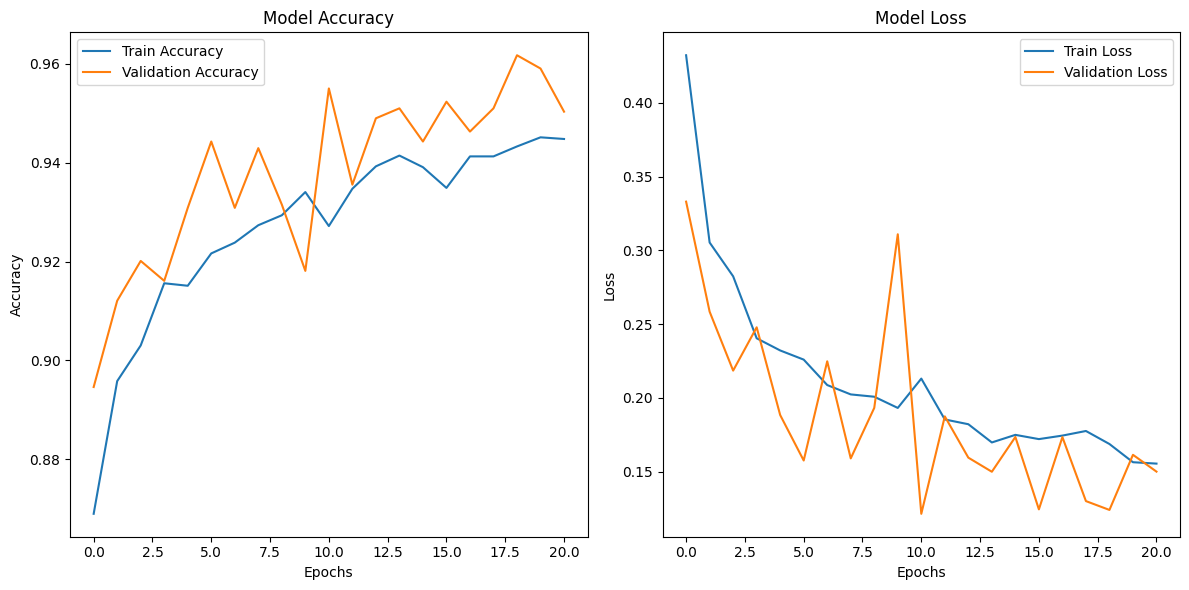

In [11]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
final_train_acc = History.history['acc'][-1]
final_val_acc = History.history['val_acc'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9448
Final Validation Accuracy: 0.9503
Final Training Loss: 0.1556
Final Validation Loss: 0.1501


In [15]:
print(f"Training stopped at epoch: {len(History.history['loss'])}")


Training stopped at epoch: 21


In [16]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/Models/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/Models/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'acc': [0.8689817190170288, 0.8958228230476379, 0.9030364155769348, 0.9156181812286377, 0.9151149392127991, 0.9216574430465698, 0.9238382577896118, 0.9273611903190613, 0.9293742775917053, 0.9340714812278748, 0.9271934032440186, 0.9347425103187561, 0.9392719268798828, 0.9414528012275696, 0.9391041994094849, 0.934910237789154, 0.9412850141525269, 0.9412850141525269, 0.9432981014251709, 0.945143461227417, 0.9448079466819763], 'loss': [0.43211761116981506, 0.30529671907424927, 0.2824030816555023, 0.24043601751327515, 0.23218956589698792, 0.2259850949048996, 0.20876753330230713, 0.20242059230804443, 0.20085512101650238, 0.1932630091905594, 0.21312525868415833, 0.18545584380626678, 0.18223139643669128, 0.16988739371299744, 0.17502792179584503, 0.17215293645858765, 0.17453019320964813, 0.17764976620674133, 0.16883131861686707, 0.1564992219209671, 0.15555685758590698], 'val_acc': [0.8946308493614197, 0.9120805263519287, 0.9201342463493347, 0.9161073565483093, 0.9308724999427795, 0.94429528713

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/Models/orange_Inception_best_model.h5'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 711s 12s/step
Confusion Matrix:
 [[892  39]
 [ 22 915]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       931
      Rotten       0.96      0.98      0.97       937

    accuracy                           0.97      1868
   macro avg       0.97      0.97      0.97      1868
weighted avg       0.97      0.97      0.97      1868


Accuracy: 0.9673447537473233

F1 Score: 0.967741935483871


In [18]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/Models/orange_inception_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/Models/orange_inception_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Models/orange_inception_results.txt


In [19]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Models/orange_inception_confusion_matrix.png
